# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.955959,False,1.230667
1,-1.707940,False,-2.627161
2,-1.533944,True,3.067586
3,-1.322582,False,-1.706979
4,-0.115925,False,0.557762
...,...,...,...
995,-1.738763,False,-2.171811
996,-0.821941,False,-2.156518
997,-0.370806,True,6.422136
998,-2.349745,False,-4.158016


<Axes: xlabel='v0'>

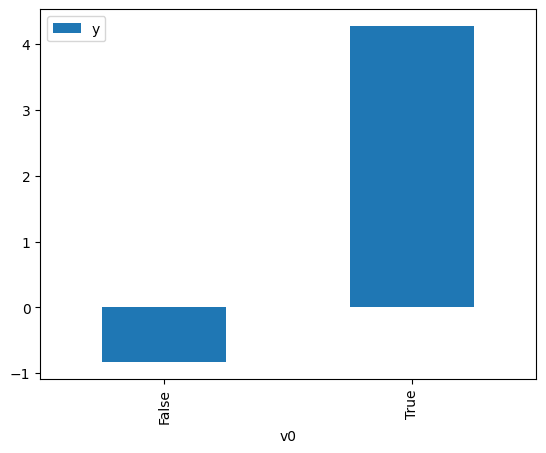

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

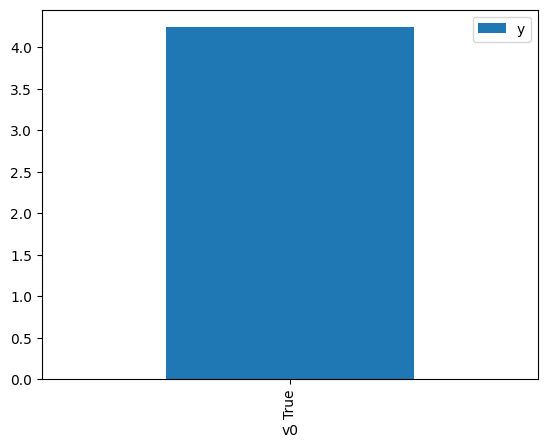

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.960354,False,-0.976524,0.569032,1.757370
1,-1.454702,False,-0.935130,0.594459,1.682201
2,-1.018716,False,-2.338603,0.572056,1.748082
3,-0.933890,False,-1.296933,0.567659,1.761620
4,-0.514971,False,-0.546583,0.545803,1.832162
...,...,...,...,...,...
995,-1.120094,False,-2.016560,0.577295,1.732216
996,-0.055038,False,1.727056,0.521606,1.917156
997,0.044139,False,-2.339918,0.516371,1.936592
998,-2.888502,False,-3.035424,0.664988,1.503788


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.411047,True,5.764423,0.503018,1.987999
1,0.778944,True,4.565741,0.522451,1.914056
2,0.305987,True,5.508695,0.497465,2.010193
3,0.312185,True,4.112236,0.497792,2.008870
4,0.757428,True,7.357266,0.521316,1.918224
...,...,...,...,...,...
995,-0.516124,True,5.785508,0.454136,2.201983
996,-0.378027,True,5.924993,0.461384,2.167392
997,-1.699982,True,2.792857,0.393102,2.543872
998,-2.092536,True,2.441121,0.373484,2.677488


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                              5152.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):                        0.00
Time:                        10:35:43   Log-Likelihood:                         -1406.1
No. Observations:                1000   AIC:                                      2816.
Df Residuals:                     998   BIC:                                      2826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1166      0.026     42.452      0.000       1.065       1.168
x2             5.0232      0.050    101.034      0.000       4.926       5.121
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.610
Skew:                           0.059   Prob(JB):                        0.737
Kurtosis:                       3.024   Cond. No.                         2.08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""